# Tutorial
In this tutorial, we'll work with the [MiniLibriMix](https://zenodo.org/record/3871592) dataset, a popular audio dataset.

We fetch raw data from Zenodo, a public repository for academic datasets. This dataset consists of audio files in wav format.

We then read wav files as numpy arrays using [Librosa](https://librosa.org/doc/latest/index.html), a popular Python package for music and audio analysis. 

We then push data to `activeloop/MiniLibriMix`, a public Hub repository. By making this dataset public, we allow others to work with the same dataset.

Finally, we will fetch data from Hub. We can fetch slices of the dataset that we need.

In [6]:
from hub.schema import Primitive, Audio, Text
from hub import transform, schema
from hub.api.datasetview import DatasetView
import hub

import librosa
from librosa import display
import numpy as np
from glob import glob
import os
import requests
import zipfile
import matplotlib.pyplot as plt

plt.style.use("ggplot")
%matplotlib inline

## Fetch data
We fetch data from Zenodo and unzip it to a folder.

In [7]:
r = requests.get('https://zenodo.org/record/3871592/files/MiniLibriMix.zip?download=1')  

with open('minilibrimix.zip', 'wb') as f:
    f.write(r.content)
    
with zipfile.ZipFile('minilibrimix.zip', 'r') as z:
    z.extractall('./data')

## Read data into arrays with Librosa
The raw files are stored in wav format, so we use Librosa to read them into arrays before pushing to Hub. That's because everything - image, audio, text - is an array (or a tensor) to Hub. 

In [33]:
# grab file names
fnames = glob("./data/MiniLibriMix/train/mix_both/*")

Text(0.5, 0, 'Amplitude')

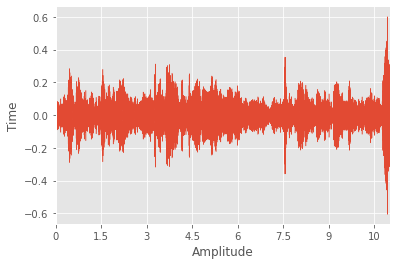

In [34]:
# lets visualized audio
audio, sr = librosa.load(fnames[0])
librosa.display.waveplot(audio, sr=sr)
plt.ylabel("Time")
plt.xlabel("Amplitude")

## Push to Hub
Once we represent audio data in arrays, we can push to Hub for collaborative work.

To do so, we have to (1) define a schema and (2) push it to Hub through a transform.

### Schemas
Schemas provide valuable information about the data itself. For example, when we push audio files (in the form of arrays), we will also want to specify that it is an `Audio` type.

In [20]:
my_schema = {
    "audio_id": Text(shape=(None, ), max_shape=(1000, )),
    "wav": Audio(shape=(None,), max_shape=(192000,), file_format="wav", dtype=float),
    "sampling_rate": Primitive(dtype=int)
}

### Transform
We operate on the list of file names - that is our input. We will "transform" this list of file names to numpy arrays through Librosa. After transforming, we want to return a dict for each sample.

In [21]:
@transform(schema=my_schema)
def load_transform(f):
    audio_id = f.split('/')[-1].split('.')[0]
    audio, sr = librosa.load(f, sr=None)
    
    return {
        'audio_id': audio_id,
        'wav': audio,
        'sampling_rate': sr
    }

In [35]:
ds = load_transform(fnames)

## Push to Hub
We can push to arbitrary locations. In this case, we will push our dataset to `activeloop/MiniLibriMix_mixboth`.

In [23]:
url = "activeloop/MiniLibriMix_mixboth"
ds2 = ds.store(url)

/Users/mynameisvinn/anaconda3/lib/python3.8/site-packages/zarr/creation.py:210: UserWarning: ignoring keyword argument 'mode'
  warn('ignoring keyword argument %r' % k)
Computing the transformation in chunks of size 87: 100%|██████████| 800/800 [01:56<00:00, 6.86 items/s] 


## Fetching from Hub
Once we have data on Hub, we can easily split it into chunks for collaborative work. 

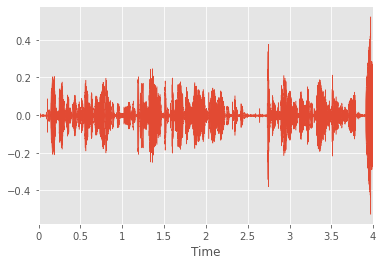

In [36]:
url = "activeloop/MiniLibriMix_mixclean"
data = Dataset(url)

idx = 0
dd = data['wav'][idx].compute()  # fetch the first sample
librosa.display.waveplot(dd)  # visualize spectrogram with librosa

## Slicing
We can also fetch slices of our dataset, thus reducing the need to move the entire dataset back and forth.

In [37]:
ds = hub.Dataset("activeloop/MiniLibriMix_mixclean")
dsv = DatasetView(ds, indexes=[1, 2, 3, 10, 11, 12])

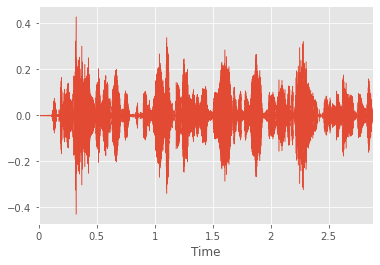

In [40]:
sliced = dsv['wav'][0].compute()
librosa.display.waveplot(sliced)  # visualize spectrogram with librosa